## On Time Shipping Classification with k-NN, Decision Tree, Naive Bayes, SVM, and Simple Neural Network

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/shipping/shipping.csv


## Data Analysis and Cleaning

In [2]:
df = pd.read_csv('/kaggle/input/shipping/shipping.csv')
df.head()

,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
0,1,D,Flight,4,2,177,3,low,F,44,1233,1
1,2,F,Flight,4,5,216,2,low,M,59,3088,1
2,3,A,Flight,2,2,183,4,low,M,48,3374,1
3,4,B,Flight,3,3,176,4,medium,M,10,1177,1
4,5,C,Flight,2,2,184,3,medium,F,46,2484,1


In [3]:
df.isna().sum()

ID                     0
Warehouse_block        0
Mode_of_Shipment       0
Customer_care_calls    0
Customer_rating        0
Cost_of_the_Product    0
Prior_purchases        0
Product_importance     0
Gender                 0
Discount_offered       0
Weight_in_gms          0
Reached.on.Time_Y.N    0
dtype: int64

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10999 entries, 0 to 10998
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID                   10999 non-null  int64 
 1   Warehouse_block      10999 non-null  object
 2   Mode_of_Shipment     10999 non-null  object
 3   Customer_care_calls  10999 non-null  int64 
 4   Customer_rating      10999 non-null  int64 
 5   Cost_of_the_Product  10999 non-null  int64 
 6   Prior_purchases      10999 non-null  int64 
 7   Product_importance   10999 non-null  object
 8   Gender               10999 non-null  object
 9   Discount_offered     10999 non-null  int64 
 10  Weight_in_gms        10999 non-null  int64 
 11  Reached.on.Time_Y.N  10999 non-null  int64 
dtypes: int64(8), object(4)
memory usage: 1.0+ MB


### Feature Description
- ID: ID Number of Customers.
- Warehouse block: The Company have big Warehouse which is divided in to block such as A,B,C,D,E.
- Mode of shipment:The Company Ships the products in multiple way such as Ship, Flight and Road.
- Customer care calls: The number of calls made from enquiry for enquiry of the shipment.
- Customer rating: The company has rated from every customer. 1 is the lowest (Worst), 5 is the highest (Best).
- Cost of the product: Cost of the Product in US Dollars.
- Prior purchases: The Number of Prior Purchase.
- Product importance: The company has categorized the product in the various parameter such as low, medium, high.
- Gender: Male and Female.
- Discount offered: Discount offered on that specific product.
- Weight in gms: It is the weight in grams.
- Reached on time: It is the target variable, where 1 Indicates that the product has NOT reached on time and 0 indicates it has reached on time.

In [5]:
df = df.drop(columns=['ID'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10999 entries, 0 to 10998
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Warehouse_block      10999 non-null  object
 1   Mode_of_Shipment     10999 non-null  object
 2   Customer_care_calls  10999 non-null  int64 
 3   Customer_rating      10999 non-null  int64 
 4   Cost_of_the_Product  10999 non-null  int64 
 5   Prior_purchases      10999 non-null  int64 
 6   Product_importance   10999 non-null  object
 7   Gender               10999 non-null  object
 8   Discount_offered     10999 non-null  int64 
 9   Weight_in_gms        10999 non-null  int64 
 10  Reached.on.Time_Y.N  10999 non-null  int64 
dtypes: int64(7), object(4)
memory usage: 945.4+ KB


In [6]:
categorical_features = ['Warehouse_block', 'Mode_of_Shipment', 'Product_importance', 'Gender']
numerical_features = [column for column in df.columns if column not in categorical_features]
for feat in categorical_features:
    print(f"Number of Unique Values of {df[feat].value_counts()}")

Number of Unique Values of Warehouse_block
F    3666
D    1834
A    1833
B    1833
C    1833
Name: count, dtype: int64
Number of Unique Values of Mode_of_Shipment
Ship      7462
Flight    1777
Road      1760
Name: count, dtype: int64
Number of Unique Values of Product_importance
low       5297
medium    4754
high       948
Name: count, dtype: int64
Number of Unique Values of Gender
F    5545
M    5454
Name: count, dtype: int64


In [7]:
df['Reached.on.Time_Y.N'].value_counts()

Reached.on.Time_Y.N
1    6563
0    4436
Name: count, dtype: int64

## Preprocessing and Visualization

### Encoding Categorical Features

In [8]:
import category_encoders as ce
from sklearn.preprocessing import LabelEncoder, StandardScaler

encoder = ce.OrdinalEncoder(cols=['Mode_of_Shipment'], return_df=True,
                           mapping=[{'col':'Mode_of_Shipment','mapping':{
                               'Ship':0,
                               'Road':1,
                               'Flight':2,
                           }}])
df_encoded = encoder.fit_transform(df)
df = df_encoded
df['Mode_of_Shipment'] = df['Mode_of_Shipment'].astype(int)


encoder = ce.OrdinalEncoder(cols=['Product_importance'], return_df=True,
                           mapping=[{'col':'Product_importance','mapping':{
                               'Low':0,
                               'Medium':1,
                               'High':2,
                           }}])
df_encoded = encoder.fit_transform(df)
df = df_encoded
df['Product_importance'] = df['Product_importance'].astype(int)

le = LabelEncoder()
df['Warehouse_block'] = le.fit_transform(df['Warehouse_block'])

le = LabelEncoder()
df['Gender'] = le.fit_transform(df['Gender'])

for feat in categorical_features:
    print(f"Encoded Data of {df[feat].value_counts()}")
    
df.info()

Encoded Data of Warehouse_block
4    3666
3    1834
0    1833
1    1833
2    1833
Name: count, dtype: int64
Encoded Data of Mode_of_Shipment
0    7462
2    1777
1    1760
Name: count, dtype: int64
Encoded Data of Product_importance
-1    10999
Name: count, dtype: int64
Encoded Data of Gender
0    5545
1    5454
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10999 entries, 0 to 10998
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Warehouse_block      10999 non-null  int64
 1   Mode_of_Shipment     10999 non-null  int64
 2   Customer_care_calls  10999 non-null  int64
 3   Customer_rating      10999 non-null  int64
 4   Cost_of_the_Product  10999 non-null  int64
 5   Prior_purchases      10999 non-null  int64
 6   Product_importance   10999 non-null  int64
 7   Gender               10999 non-null  int64
 8   Discount_offered     10999 non-null  int64
 9   Weight_in_gms      

### Heatmap

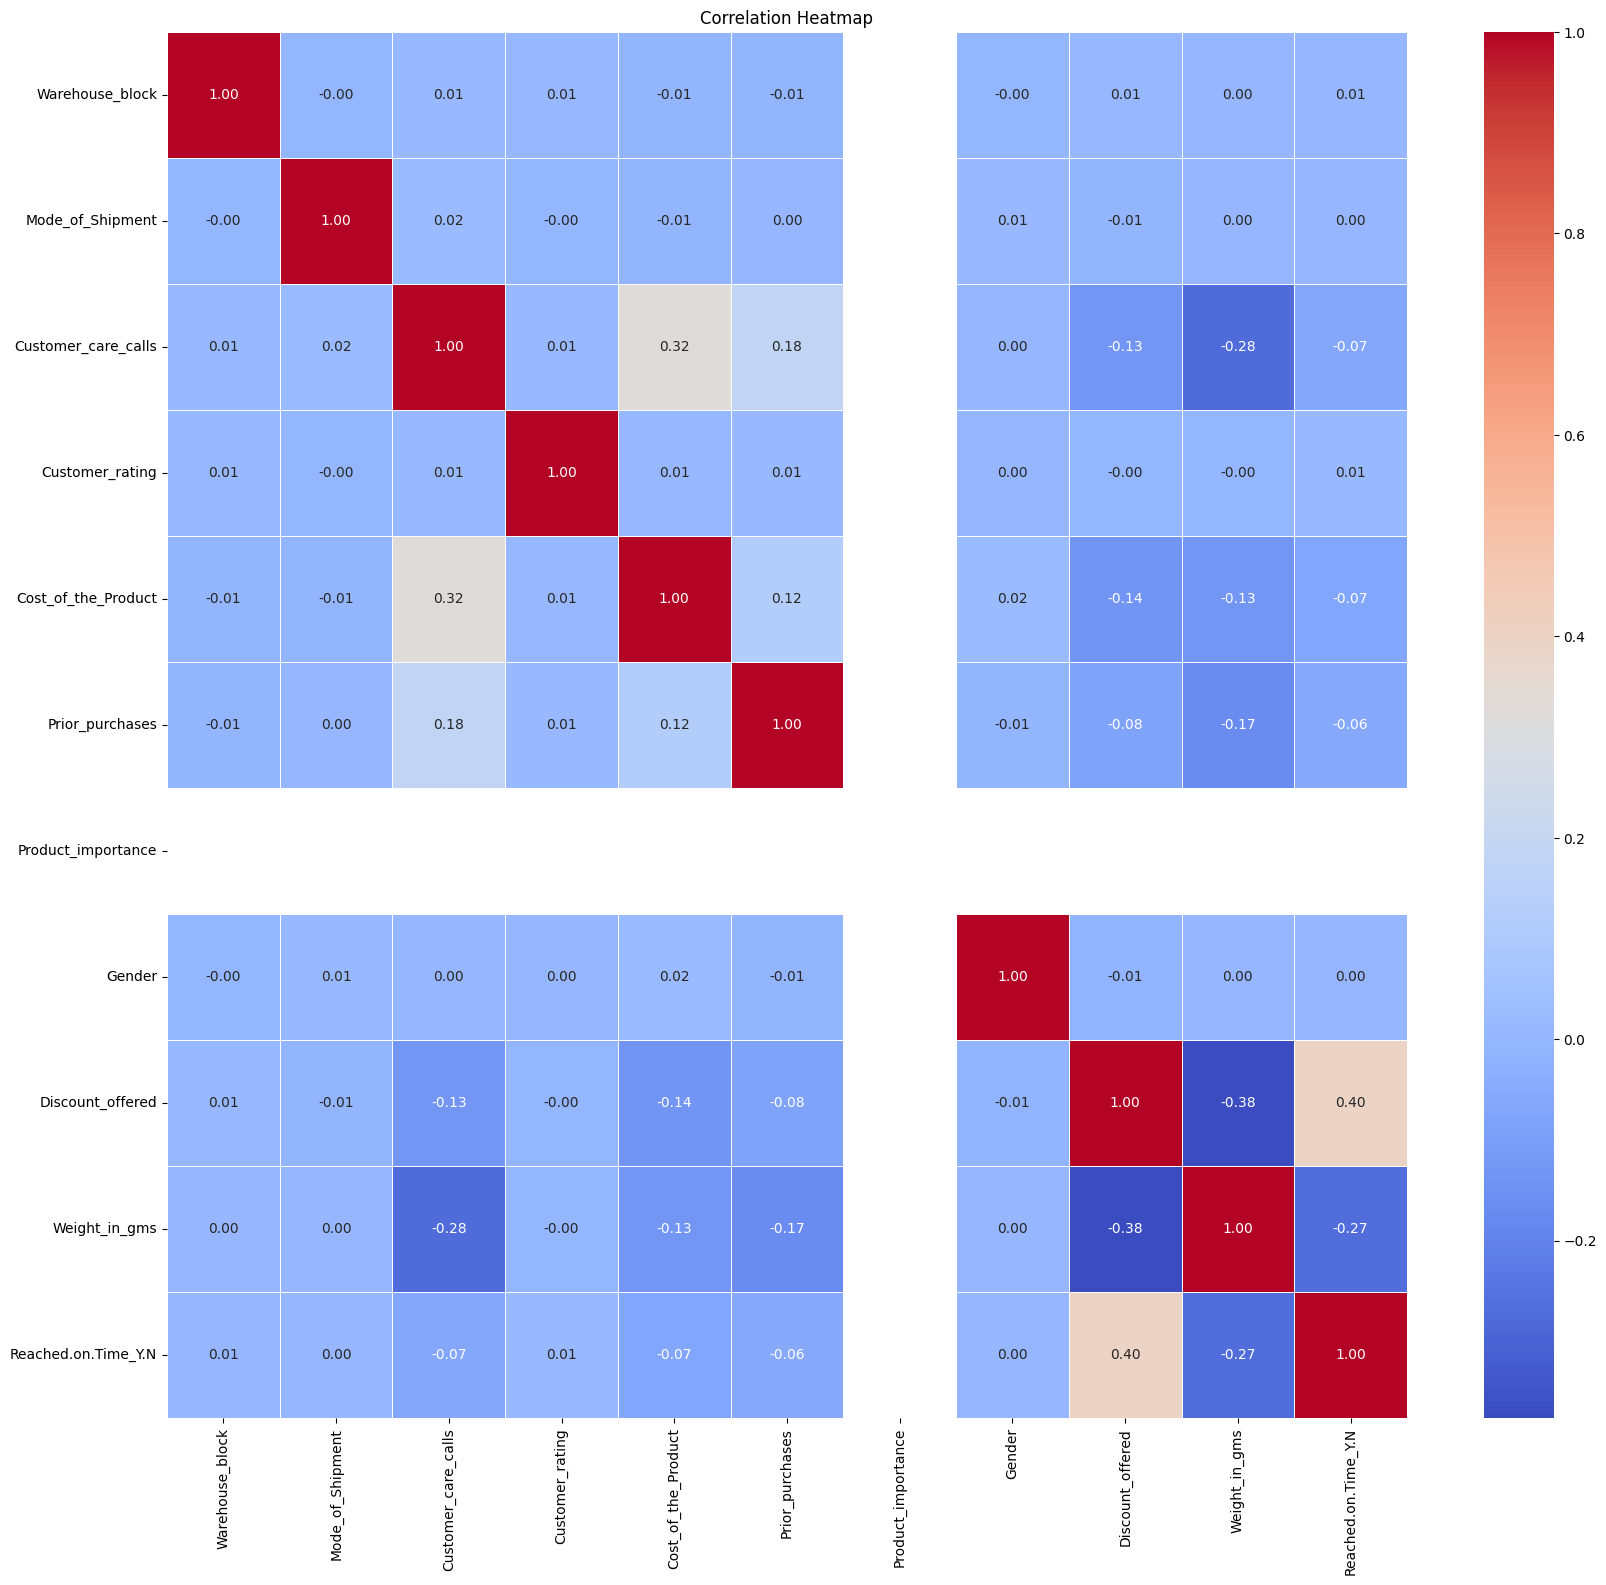

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the correlation matrix
corr_matrix = df.corr()

# Create a heatmap
plt.figure(figsize=(20, 18))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

In [13]:
df.describe()

,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
count,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000,10999.0,10999.000000,10999.000000,10999.000000,10999.000000
mean,2.333394,0.483135,4.054459,2.990545,210.196836,3.567597,-1.0,0.495863,13.373216,3634.016729,0.596691
std,1.490726,0.756894,1.141490,1.413603,48.063272,1.522860,0.0,0.500006,16.205527,1635.377251,0.490584
min,0.000000,0.000000,2.000000,1.000000,96.000000,2.000000,-1.0,0.000000,1.000000,1001.000000,0.000000
25%,1.000000,0.000000,3.000000,2.000000,169.000000,3.000000,-1.0,0.000000,4.000000,1839.500000,0.000000
50%,3.000000,0.000000,4.000000,3.000000,214.000000,3.000000,-1.0,0.000000,7.000000,4149.000000,1.000000
75%,4.000000,1.000000,5.000000,4.000000,251.000000,4.000000,-1.0,1.000000,10.000000,5050.000000,1.000000
max,4.000000,2.000000,7.000000,5.000000,310.000000,10.000000,-1.0,1.000000,65.000000,7846.000000,1.000000


## Classification With Varying Models

### Import Dependencies

In [14]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report

# k-Nearest Neighbors
from sklearn.neighbors import KNeighborsClassifier
# Decicion Tree
from sklearn.tree import DecisionTreeClassifier
# Naive Bayes Models
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
# SUpport Vector Machine
from sklearn.svm import SVC
# Artificial Neural Network
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.utils import to_categorical

In [16]:
X = df.drop('Reached.on.Time_Y.N', axis=1)
y = df['Reached.on.Time_Y.N']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

K-Nearest Neighbours

In [17]:
knn = KNeighborsClassifier(n_neighbors=5) 
# Train the model
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

knn_accuracy = accuracy_score(y_test, y_pred)
# Evaluate the performance
print("Accuracy:", knn_accuracy)
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.644090909090909
Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.60      0.58       895
           1       0.71      0.67      0.69      1305

    accuracy                           0.64      2200
   macro avg       0.63      0.64      0.64      2200
weighted avg       0.65      0.64      0.65      2200



In [19]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {'n_neighbors': range(1, 31)}

# Initialize the GridSearchCV object
grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='accuracy')

# Fit the model
grid_search.fit(X_train, y_train)

# Best parameters and score
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation accuracy:", grid_search.best_score_)

# Use the best model to predict
best_knn = grid_search.best_estimator_
y_pred = best_knn.predict(X_test)

knn_accuracy = accuracy_score(y_test, y_pred)
# Evaluate the best model
print("Accuracy with best parameters:", knn_accuracy)
print("Classification Report with best parameters:")
print(classification_report(y_test, y_pred))

Best parameters: {'n_neighbors': 24}
Best cross-validation accuracy: 0.6634851284304099
Accuracy with best parameters: 0.6631818181818182
Classification Report with best parameters:
              precision    recall  f1-score   support

           0       0.56      0.77      0.65       895
           1       0.79      0.59      0.68      1305

    accuracy                           0.66      2200
   macro avg       0.68      0.68      0.66      2200
weighted avg       0.70      0.66      0.67      2200



In [20]:
dt =  DecisionTreeClassifier(random_state=42)
# Train the model
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)

dt_accuracy = accuracy_score(y_test, y_pred)
# Evaluate the performance
print("Accuracy:", dt_accuracy)
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.65
Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.55      0.56       895
           1       0.70      0.72      0.71      1305

    accuracy                           0.65      2200
   macro avg       0.64      0.63      0.64      2200
weighted avg       0.65      0.65      0.65      2200



In [21]:
gNB = GaussianNB()

# Train the model
gNB.fit(X_train, y_train)
y_pred = gNB.predict(X_test)

gNB_accuracy = accuracy_score(y_test, y_pred)
# Evaluate the performance
print("Accuracy:", gNB_accuracy)
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.655
Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.99      0.70       895
           1       0.98      0.43      0.60      1305

    accuracy                           0.66      2200
   macro avg       0.76      0.71      0.65      2200
weighted avg       0.80      0.66      0.64      2200



In [22]:
bNB = BernoulliNB()

# Train the model
bNB.fit(X_train, y_train)
y_pred = bNB.predict(X_test)

bNB_accuracy = accuracy_score(y_test, y_pred)
# Evaluate the performance
print("Accuracy:", bNB_accuracy)
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.6718181818181819
Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.78      0.66       895
           1       0.80      0.60      0.68      1305

    accuracy                           0.67      2200
   macro avg       0.68      0.69      0.67      2200
weighted avg       0.71      0.67      0.67      2200



In [23]:
svm = SVC()
# Train the model
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)

svm_accuracy = accuracy_score(y_test, y_pred)
# Evaluate the performance
print("Accuracy:", svm_accuracy)
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.6740909090909091
Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.88      0.69       895
           1       0.86      0.53      0.66      1305

    accuracy                           0.67      2200
   macro avg       0.71      0.71      0.67      2200
weighted avg       0.74      0.67      0.67      2200



In [24]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)

X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

num_class = y_categorical.shape[1]

# Initialize the ANN
ann = Sequential()
ann.add(Input(shape=(X.shape[1],)))
ann.add(Dense(units=64, activation='relu'))
ann.add(Dense(units=32, activation='relu'))
ann.add(Dense(units=16, activation='relu'))
ann.add(Dense(units=num_class, activation='softmax'))

# Compile the model
ann.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the ANN on the training data
history = ann.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5741 - loss: 0.6466 - val_accuracy: 0.6597 - val_loss: 0.5247
Epoch 2/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6607 - loss: 0.5368 - val_accuracy: 0.6659 - val_loss: 0.5188
Epoch 3/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6643 - loss: 0.5258 - val_accuracy: 0.6716 - val_loss: 0.5143
Epoch 4/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6753 - loss: 0.5155 - val_accuracy: 0.6670 - val_loss: 0.5166
Epoch 5/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6790 - loss: 0.5105 - val_accuracy: 0.6670 - val_loss: 0.5146
Epoch 6/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6803 - loss: 0.5061 - val_accuracy: 0.6551 - val_loss: 0.5171
Epoch 7/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6827 - loss: 0.5102 - val_accuracy: 0.6619 - val_loss: 0.5174
Epoch 8/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6905 - loss: 0.5074 - val_accuracy: 0.

In [25]:
test_loss, test_accuracy = ann.evaluate(X_test, y_test)
print(f'Test accuracy: {test_accuracy}')
ann_accuracy = test_accuracy

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 808us/step - accuracy: 0.6578 - loss: 0.5949
Test accuracy: 0.6540908813476562


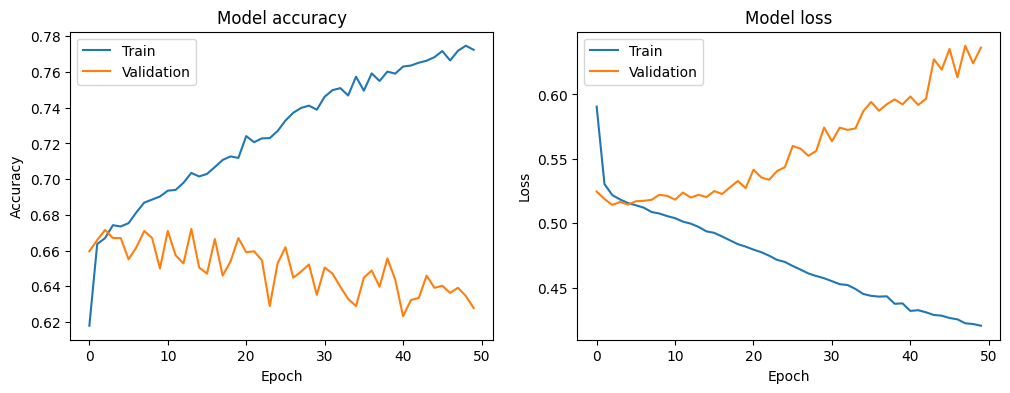

In [26]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

Accuracy For k-NN:  0.6631818181818182
Accuracy For Decicion Tree:  0.65
Accuracy For Gaussian NB:  0.655
Accuracy For Bernoulli NB:  0.6718181818181819
Accuracy For SVM:  0.6740909090909091
Accuracy For ANN:  0.6540908813476562


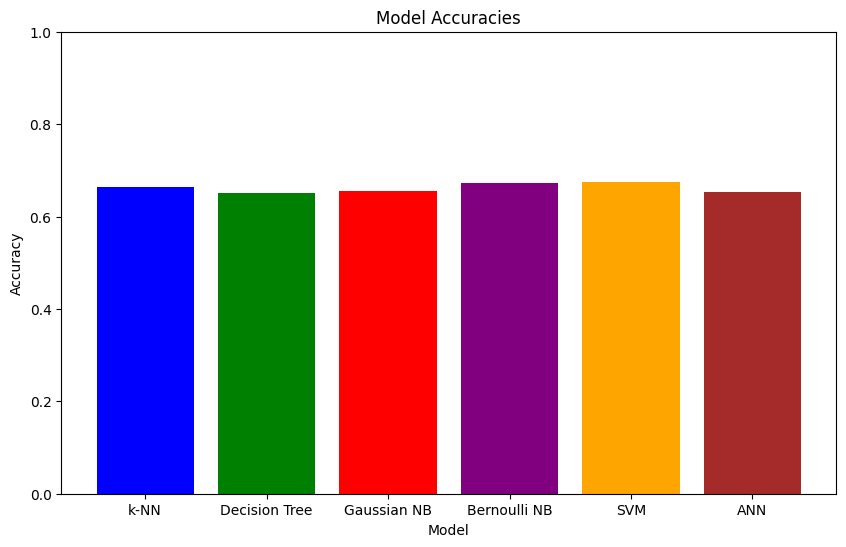

In [28]:
models = ['k-NN', 'Decision Tree', 'Gaussian NB', 'Bernoulli NB', 'SVM', 'ANN']
accuracies = [knn_accuracy, dt_accuracy, gNB_accuracy, bNB_accuracy, svm_accuracy, ann_accuracy]
print("Accuracy For k-NN: ", knn_accuracy)
print("Accuracy For Decicion Tree: ", dt_accuracy)
print("Accuracy For Gaussian NB: ", gNB_accuracy)
print("Accuracy For Bernoulli NB: ", bNB_accuracy)
print("Accuracy For SVM: ", svm_accuracy)
print("Accuracy For ANN: ", ann_accuracy)

plt.figure(figsize=(10, 6))
plt.bar(models, accuracies, color=['blue', 'green', 'red', 'purple', 'orange', 'brown'])
plt.ylim([0, 1])
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Accuracies')
plt.show()

## Conclusion

The Models performed rather badly on this dataset. The best performing model is Support Vector Classifier